# Collaborative Filtering Song Recommendation System  

In this notebook, we employed two algorithms (popularity benchmark and ALS) to generated two different playlists: 
- Hot Song playlist - based on song popularity
- Personalized playlist - based on Alternative Least Square algorithm 

_______________________________________________________________________


# Objective

- To build a usable and comprehensive song recommendation system for music-streaming industry.
- To compare and combine poplarity based, collaborative filtering based and content-based methodology to target different users 
- To create a system that predicts the likelihood of a certain user will like a song or not.
- To create or improve different retention and engagement strategies on targeted users. 

_________________________________________________________________________

# Hypotheses

### `Naive Recommendation System`: 

   - Popularity is the benchmark for recommending songs because it is better than random guesses.



### `Collaborative Filtering Recommendation System`: 

   - If user A liked the same song as user B, A would also like to have similar taste as B for other B’s favorites.
______________________________________________________________________________

# Pipeline

## `Load Data`

- Data orginially were aggregated, cleaned and stored on S3 storage on Google Cloud. 
- Set up Spark environment.
- Convert Pandas DataFrame to Spark DataFrame.

## `Preprocess Data`

- Convert unique IDs to interger
- Merge unique user IDs and track IDs 
- Cache in memory to save space

In total, there are 1 million unique users and 385,000 unique tracks.

## `Exploratory Data Analysis`

- How many tracks are played more than once? 
- How many tracks are played from 1 to 5 times ?

## `Algorithm Development`


###  1. Popularity Benchmark

- The data were filtered by **total frequency based on listening history**, then top 10 heated tracks were selected. This would be the baseline saver for cold-start problem.


### 2. Collaborative Filtering Algorithm

<img src="img/CFAlgorithm.png">

- The main assumption for collaborative filtering here is that the **users (listeners in our case) who have agreed in the past are very likely to agree in the future**.


- In terms of the ratings, traditional way was implemented by utilizing the **listening frequency as the rating**. The assumption when lacking explicit rating is that a higher listening frequency equates to a higher rating.


- For **ALS**, **a matrix with frequency of each song played by each user** was constructed. The high-level idea is to approximate the matrix by factorizing it as the product of two matrices: the user matrix that represents each user, while the item matrix describes properties of each track.

<img src="img/ALSmatrix.png">


- **Grid-search** with **cross-validation** were implemented during Spark ML pipeline for hyperparameters tunning:
       
       - maxIter (the max number of iterations)
   
       - rank (the number of latent factors, which basically determined the shape of matrix)
   
       - regParam (the regularization parameter).
   

## `Evaluation with RMSE`

- For a reasonable result, two matrices were created so that the error for the known user-song pairs is minimized. The error here refers to the **rooted mean squared error (RMSE)**. 


- In a more detailed technical level, ALS would first fill the user matrix with a random value, and then optimize the song matrix value by minimizing the error. After that, it “alters”, which means it would hold the song matrix and optimize the value of the user’s matrix. This step minimizes two loss functions alternatively and should achieve some optima.


### Evaluation on ALS algorithm (Collaborative Filtering)

Many songs have only been listened once. Although the second model has a higher RMSE on test, it behaves relatively better when compared to average frequency. Since those tracks were listened more, we inferred those songs can better represent users’ tastes. The circled items might be of highest recommendation quality.


<img src="img/ALSresult.png">

________________________________________________________________



# Load Data

In [1]:
from google.cloud import storage
import os
from io import BytesIO
import pandas as pd

#Connect to GCP bucket and assign the bucket_name and specify the file name
# bucket_name = "lj-bucket1" #Assign the bucket name where your file is stored
# storage_client = storage.Client()
# bucket = storage_client.get_bucket(bucket_name)

In [12]:
# spark configuration
# I might be wrong, but even running 3G file on spark is very memory consuming

from pyspark import SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *


conf = SparkConf().setAppName("App")
conf = (conf.set('spark.executor.memory', '30G')
            .set('spark.driver.memory', '30G')
            .set('spark.driver.maxResultSize', '30G'))

spark = SparkSession.builder\
                    .config(conf=conf)\
                    .appName('LJ')\
                    .getOrCreate()

In [13]:
# blob = storage.blob.Blob("tracks_metadata.csv", bucket)
# blob

In [14]:
#content = blob.download_as_string()
df = pd.read_csv('../data/tmp/tracks_metadata.csv')

In [15]:
# Convert Pandas Dataframe to Spark Dataframe with schema    

metadata_schema = StructType(
   [StructField('track_id', StringType(), True),
   StructField('title', StringType(), True),
   StructField('song_id', StringType(), True),
   StructField('release', StringType(), True),
   StructField('artist_id', StringType(), True),
   StructField('artist_mbid', StringType(), True),
   StructField('artist_name', StringType(), True),
   StructField('duration', DoubleType(), True),
   StructField('artist_familiarity', DoubleType(), True),
   StructField('artist_hotttness', DoubleType(), True),
   StructField('year', IntegerType(), True)]
)


metadata_df = spark.createDataFrame(df, schema=metadata_schema) 

/Users/aritra/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [16]:
# read csv directly from google cloud - RECOMMENDED
# pip install gcsfs
# should be <5 mins

df = pd.read_csv('../data/tmp/listening_history.csv')

In [17]:
# It seems this step requires huge Memory; 
# be sure to upgrade your system to at least 15GB RAM (>30GB RAM suggested)
# might take over 10 mins

history_schema = StructType(
  [StructField('user_id', StringType()),
   StructField('track_id', StringType()),
   StructField('frequency', IntegerType())]
)

history_df = spark.createDataFrame(df, schema=history_schema)

/Users/aritra/Library/Python/3.9/lib/python/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [18]:
# take a quick look
history_df.show(5)

23/03/30 22:23:20 WARN TaskSetManager: Stage 8 contains a task of very large size (123992 KiB). The maximum recommended task size is 1000 KiB.


23/03/30 22:23:24 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 8 (TID 27): Attempting to kill Python Worker
+--------------------+------------------+---------+
|             user_id|          track_id|frequency|
+--------------------+------------------+---------+
|b80344d063b5ccb32...|TRIQAUQ128F42435AD|        1|
|7c86176941718984f...|TRIQAUQ128F42435AD|        1|
|76235885b32c4e8c8...|TRIQAUQ128F42435AD|        3|
|250c0fa2a77bc6695...|TRIQAUQ128F42435AD|        1|
|3f73f44560e822344...|TRIQAUQ128F42435AD|        6|
+--------------------+------------------+---------+
only showing top 5 rows



# Preprocess Data

In [19]:
from pyspark.sql import functions as F

# change ids to int
user_id = history_df.select('user_id')\
                    .distinct()\
                    .select('user_id', F.monotonically_increasing_id()\
                    .alias('new_userid'))


track_id = history_df.select('track_id')\
                     .distinct()\
                     .select('track_id', F.monotonically_increasing_id()\
                     .alias('new_trackid'))

In [20]:
# get total unique users and songs
unique_users = user_id.count()
unique_tracks = track_id.count()
print('Number of unique users: {0}'.format(unique_users))
print('Number of unique songs: {0}'.format(unique_tracks))

23/03/30 22:23:25 WARN TaskSetManager: Stage 9 contains a task of very large size (123992 KiB). The maximum recommended task size is 1000 KiB.


23/03/30 22:24:10 WARN TaskSetManager: Stage 15 contains a task of very large size (123992 KiB). The maximum recommended task size is 1000 KiB.


Number of unique users: 439429
Number of unique songs: 351246


### There are more than 1 Million Unique Users and More than 385K unique tracks.

In [21]:
# join all data
total_df = history_df.join(user_id, 'user_id')\
                     .join(track_id, 'track_id')

In [22]:
#total_df.count()

23/03/30 22:25:03 WARN TaskSetManager: Stage 21 contains a task of very large size (123992 KiB). The maximum recommended task size is 1000 KiB.


23/03/30 22:25:55 WARN TaskSetManager: Stage 22 contains a task of very large size (123992 KiB). The maximum recommended task size is 1000 KiB.


23/03/30 22:26:35 WARN TaskSetManager: Stage 23 contains a task of very large size (123992 KiB). The maximum recommended task size is 1000 KiB.


ERROR:root:KeyboardInterrupt while sending command.=========>       (7 + 1) / 8]
Traceback (most recent call last):
  File "/Users/aritra/Library/Python/3.9/lib/python/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/aritra/Library/Python/3.9/lib/python/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

### Let's make life easier. As we are running the same algorithms anyway, and the memory on cloud is really expensive so we can cache in memory.

In [23]:
# cache in memory 
# because we will revisit them from time to time

metadata_df.cache()
total_df.cache()

DataFrame[track_id: string, user_id: string, frequency: int, new_userid: bigint, new_trackid: bigint]

In [ ]:
# check memory usage
! free -m

zsh:1: command not found: free


# Exploratory Data Analysis

In [24]:
# count entries and listens
entries = total_df.count()

23/03/30 22:33:08 WARN TaskSetManager: Stage 26 contains a task of very large size (123992 KiB). The maximum recommended task size is 1000 KiB.


23/03/30 22:33:46 WARN TaskSetManager: Stage 24 contains a task of very large size (123992 KiB). The maximum recommended task size is 1000 KiB.


23/03/30 22:34:25 WARN TaskSetManager: Stage 25 contains a task of very large size (123992 KiB). The maximum recommended task size is 1000 KiB.


In [25]:
listens = []
for i in range(10):
    listens.append(float(total_df.filter(total_df.frequency == i+1).count())/entries*100)

In [26]:
numbers = [i for i in range(1, 11)]

d = {'number': numbers, 'listen': listens}
df = pd.DataFrame(data=d)
df

,number,listen
0,1,59.371755
1,2,15.214531
2,3,6.676318
3,4,3.759300
4,5,4.626892
5,6,2.075115
6,7,1.396437
7,8,1.011821
8,9,0.755479
9,10,0.893361


### Around 59.6% of the tracks are played at least once. 

Text(0.5, 1.0, 'Percentage of the Track Play Frequency')

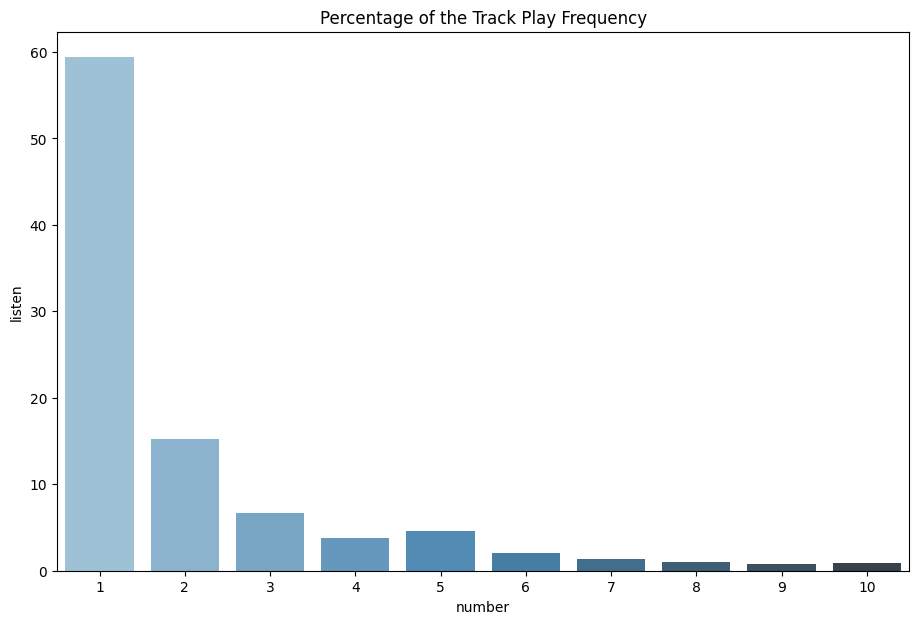

In [27]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(11, 7))
sns.barplot(x='number', y='listen', data=df, palette="Blues_d")
plt.title("Percentage of the Track Play Frequency")

In [28]:
import numpy as np

total_listens = np.cumsum(listens)
d = {'number': numbers, 'cummulative_listen': total_listens}
df = pd.DataFrame(data=d)
df

,number,cummulative_listen
0,1,59.371755
1,2,74.586286
2,3,81.262604
3,4,85.021903
4,5,89.648796
5,6,91.723910
6,7,93.120347
7,8,94.132169
8,9,94.887648
9,10,95.781009


### Almost 90% of the songs are played between 1 to 5 times. (<= 5 times)

/var/folders/83/ksr3jszs0vx_pckx8q4h__y00000gq/T/ipykernel_76768/4058758120.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='number', y='cummulative_listen', data=df, palette="Blues_d")


Text(0.5, 1.0, 'Percentage of the Track Play Frequency')

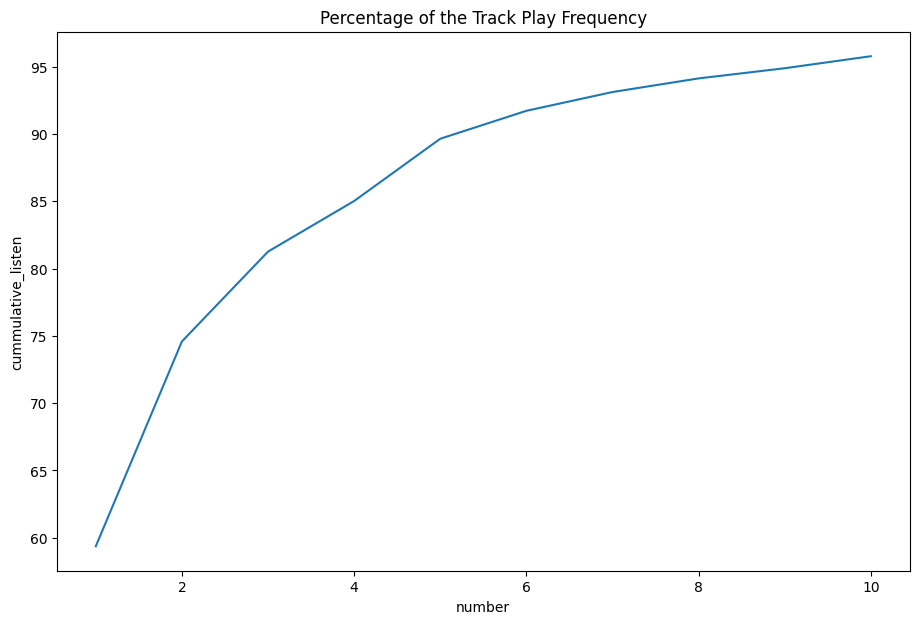

In [29]:
plt.figure(figsize=(11, 7))
sns.lineplot(x='number', y='cummulative_listen', data=df, palette="Blues_d")
plt.title("Percentage of the Track Play Frequency")

# Naive Recommendation - By popularity

- Generate hot tracks playlist

In [30]:
tracks_with_listens = total_df.groupBy('track_id')\
                              .agg(F.count(total_df.frequency).alias('user_count'),
                                   F.sum(total_df.frequency).alias('total_frequency'))\
                              .orderBy('total_frequency', ascending = False)

tracks_with_listens.show(3, truncate=False)

+------------------+----------+---------------+
|track_id          |user_count|total_frequency|
+------------------+----------+---------------+
|TRAEHHJ12903CF492F|36245     |321420         |
|TRGXQES128F42BA5EB|39272     |277820         |
|TRONYHY128F92C9D11|34846     |227649         |
+------------------+----------+---------------+
only showing top 3 rows



In [31]:
# Join with metadata 
# Get detailed song information

tracks_with_listens_names = tracks_with_listens.join(metadata_df, 'track_id' ) \
                                               .filter('user_count >= 200') \
                                               .select('artist_name', 'title', 'user_count','total_frequency') \
                                               .orderBy('total_frequency', ascending = False)

# display 20 most popular songs
tracks_with_listens_names.show(n=10, truncate = False)

23/03/30 22:39:42 WARN TaskSetManager: Stage 150 contains a task of very large size (8184 KiB). The maximum recommended task size is 1000 KiB.


+----------------------------------------------------------------------+-------------------------------------------------------------------+----------+---------------+
|artist_name                                                           |title                                                              |user_count|total_frequency|
+----------------------------------------------------------------------+-------------------------------------------------------------------+----------+---------------+
|Dwight Yoakam                                                         |You're The One                                                     |36245     |321420         |
|Björk                                                                 |Undo                                                               |39272     |277820         |
|Kings Of Leon                                                         |Revelry                                                            |34846     |227649   

In [32]:
# try different display options
tracks_with_listens_names.show(n=10)

23/03/30 22:39:59 WARN TaskSetManager: Stage 157 contains a task of very large size (8184 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+----------+---------------+
|         artist_name|               title|user_count|total_frequency|
+--------------------+--------------------+----------+---------------+
|       Dwight Yoakam|      You're The One|     36245|         321420|
|               Björk|                Undo|     39272|         277820|
|       Kings Of Leon|             Revelry|     34846|         227649|
|            Harmonia|       Sehr kosmisch|     47559|         183255|
|Barry Tuckwell/Ac...|Horn Concerto No....|     29966|         168331|
|Florence + The Ma...|Dog Days Are Over...|     39238|         155058|
|         OneRepublic|             Secrets|     33541|         125917|
|    Five Iron Frenzy|              Canada|     19694|         118127|
|            Tub Ring|             Invalid|     16185|         117526|
|           Sam Cooke|    Ain't Misbehavin|     15818|         104667|
+--------------------+--------------------+----------+---------------+
only s

In [33]:
tracks_with_listens_names.select("artist_name", "title").show(n=10, truncate=False)

23/03/30 22:40:12 WARN TaskSetManager: Stage 164 contains a task of very large size (8184 KiB). The maximum recommended task size is 1000 KiB.


+----------------------------------------------------------------------+-------------------------------------------------------------------+
|artist_name                                                           |title                                                              |
+----------------------------------------------------------------------+-------------------------------------------------------------------+
|Dwight Yoakam                                                         |You're The One                                                     |
|Björk                                                                 |Undo                                                               |
|Kings Of Leon                                                         |Revelry                                                            |
|Harmonia                                                              |Sehr kosmisch                                                      |
|Barry Tuckwe

# Collaborative Filtering

Assumption: if person A and B share similar listening history, A might be also interested in B's other songs.

For this history, as for each user, we have song plays frequency for only a subset of the songs, because not all users listened to all songs. 

The intuition is that collaborative filtering would be able to approximate the matrix; which decompomises the matrix as the product of "user property" cross "song property".

Optimization with ALS algorithm:

1. First randomly fill in the users matrix.
2. Optimize the song values that the error is minimized (least squared error).
3. Then, hold song's value fixed and optimize the user matrix (that's why it's called alternation).

In [34]:
# train, validation, test  ---  0.6, 0.2, 0.2

train_df, valid_df, test_df = total_df.randomSplit([0.6, 0.2, 0.2])

In [35]:
# make sure all frequency in double type

train_df = train_df.withColumn("frequency", train_df["frequency"].cast(DoubleType()))
valid_df = valid_df.withColumn("frequency", valid_df["frequency"].cast(DoubleType()))
test_df = test_df.withColumn("frequency", test_df["frequency"].cast(DoubleType()))

In [36]:
# ALS has strict requirement for data type
# bigint is very problematic
# make bigint to int

train_df = train_df.withColumn("new_userid", train_df["new_userid"].cast(IntegerType()))
train_df = train_df.withColumn("new_trackid", train_df["new_trackid"].cast(IntegerType()))

valid_df = valid_df.withColumn("new_userid", valid_df["new_userid"].cast(IntegerType()))
valid_df = valid_df.withColumn("new_trackid", valid_df["new_trackid"].cast(IntegerType()))

test_df = test_df.withColumn("new_userid", test_df["new_userid"].cast(IntegerType()))
test_df = test_df.withColumn("new_trackid", test_df["new_trackid"].cast(IntegerType()))

In [37]:
# Cache those to save memory

train_df = train_df.cache()
valid_df = valid_df.cache()
test_df = test_df.cache()

In [38]:
train_df.show(5)

+------------------+--------------------+---------+----------+-----------+
|          track_id|             user_id|frequency|new_userid|new_trackid|
+------------------+--------------------+---------+----------+-----------+
|TRAADQX128F422B4CF|00c54b607a321a950...|      1.0|      2188|        345|
|TRAADQX128F422B4CF|01cd07155ccfcfc50...|     13.0|      1312|        345|
|TRAADQX128F422B4CF|05df754fcf0e31da0...|      2.0|      2032|        345|
|TRAADQX128F422B4CF|06e39f9d2033c0e0a...|      1.0|       509|        345|
|TRAADQX128F422B4CF|10afd8a7eab88c47e...|      1.0|      1335|        345|
+------------------+--------------------+---------+----------+-----------+
only showing top 5 rows



## Alternative Least Square (ALS) with Spark ML


- Initialize ALS with Spark ML
- Set RMSE as evaluation metric
- Perform Cross Validation - Grid Search to find the best parameters
- Generate personalized playlists based on listening history

In [39]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# initialization

als = ALS().setMaxIter(5)\
            .setItemCol("new_trackid")\
            .setRatingCol("frequency")\
            .setUserCol("new_userid")

In [40]:
# evaluation metric - RMSE

eval_metric = RegressionEvaluator(predictionCol="prediction",
                           labelCol="frequency",
                           metricName="rmse")

In [41]:
# hyper parameter space for cross validation - grid search

ranks = [6, 8, 10, 12]
regParams = [0.2, 0.25, 0.3]
errors = [[0]*len(ranks)]*len(regParams)
models = [[0]*len(ranks)]*len(regParams)
min_error = float('inf')
i = 0

In [42]:
for regParam in regParams:
    j = 0
    for rank in ranks:
        # grid search starts
        als.setParams(rank = rank, regParam = regParam)
        model = als.fit(train_df)
        
        # validation performance
        predict_df = model.transform(valid_df)

        # Remove NaN values from prediction
        predicted_plays_df = predict_df.filter(predict_df.prediction != float('nan'))
        predicted_plays_df = predicted_plays_df.withColumn("prediction", F.abs(F.round(predicted_plays_df["prediction"],0)))

        error = eval_metric.evaluate(predicted_plays_df)
        errors[i][j] = error
        models[i][j] = model
        print ('rank %s, regularization parameter %s the RMSE is %s' % (rank, regParam, error))
        if error < min_error:
            min_error = error
            best_params = [i,j]
        j += 1
    i += 1

23/03/30 22:41:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/30 22:41:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


23/03/30 22:41:45 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


rank 6, regularization parameter 0.2 the RMSE is 6.136559727301405


rank 8, regularization parameter 0.2 the RMSE is 6.136968497633034


rank 10, regularization parameter 0.2 the RMSE is 6.137380150318927


rank 12, regularization parameter 0.2 the RMSE is 6.138074378460237


rank 14, regularization parameter 0.2 the RMSE is 6.137457966803292


rank 6, regularization parameter 0.25 the RMSE is 6.136745582055576


rank 8, regularization parameter 0.25 the RMSE is 6.136776753827548


rank 10, regularization parameter 0.25 the RMSE is 6.137312278782019


: 

### On the whole dataset, it doesn't help that much to tune the hyperparameter. 

In [ ]:
# best parameters

als.setRegParam(regParams[best_params[0]])
als.setRank(ranks[best_params[1]])
print ('The best regularization parameter is %s' % regParams[best_params[0]])
print ('The best rank is %s' % ranks[best_params[1]])
my_model = models[best_params[0]][best_params[1]]

In [ ]:
#Example of predicted plays
predicted_plays_df.show(10)

+------------------+--------------------+---------+----------+-----------+----------+
|          track_id|             user_id|frequency|new_userid|new_trackid|prediction|
+------------------+--------------------+---------+----------+-----------+----------+
|TRJUFSI128F42BA722|149c6088e2ff76512...|      1.0|       148|        148|       2.0|
|TRKOZVY12903CFDBD0|f2ae4721376a83b97...|     18.0|       148|        148|       2.0|
|TRPZOLS128F427EEFB|d8b77ab59b79b6cd9...|      1.0|       148|        148|       2.0|
|TRMPSGR128F92D31F3|999ca7ef5c7f1ad44...|      1.0|       148|        148|       2.0|
|TRHPMLM128F92F10C5|0981a87799e11bbc9...|      1.0|       148|        148|       2.0|
|TRDQRVE128F427BFAF|051574346cd47b612...|      1.0|       148|        148|       2.0|
|TRYJCWT128F42635D6|ba9cf21677846e06c...|      1.0|       148|        148|       2.0|
|TRRSGAK128E0786BAE|16a5d42ae7a16eac2...|      4.0|       463|        148|       3.0|
|TRXZKTY128F149ACD8|d376d833b4934d516...|      5.0|   

# Evaluation on testing data

In [ ]:
predict_df = my_model.transform(test_df)

# Remove nan
predicted_test_df = predict_df.filter(predict_df.prediction != float('nan'))
# round to int
predicted_test_df = predicted_test_df.withColumn("prediction", F.abs(F.round(predicted_test_df["prediction"],0)))
test_RMSE = eval_metric.evaluate(predicted_test_df)

print('The final RMSE on the test set is {0}'.format(test_RMSE))

The final RMSE on the test set is 6.461274416023


### It seems to be a nice score. We need to examine the result to check if it can make sense.

# Evaluation on a specific user

In [ ]:
# randomly assign a user
user = 101
tracks = total_df.filter(total_df.new_userid == user)\
                .join(metadata_df, 'track_id') \
                .select('new_trackid', 'artist_name', 'title') 

In [ ]:
print("Tracks that user already listened to:")
tracks.show(10, truncate=False)

Tracks that user already listened to:
+------------+-----------------+-----------------------------------------------------+
|new_trackid |artist_name      |title                                                |
+------------+-----------------+-----------------------------------------------------+
|42949673382 |Spitalfield      |Those Days You Felt Alive (Album Version)            |
|137438953622|Yellowcard       |Fighting                                             |
|146028888098|Rise Against     |Audience Of One                                      |
|180388626438|Cage The Elephant|Back Against The Wall                                |
|206158430233|Rise Against     |Under The Knife                                      |
|214748364996|Gym Class Heroes |It's OK_ But Just This Once! (Explicit Album Version)|
|292057776186|Dr Feelgood      |Riot In Cell Block Number Nine                       |
|352187318273|Cage The Elephant|Ain't No Rest For The Wicked (Original Version)      |
|3607

In [ ]:
# generate unlistened tracks

listened_track = []
for track in tracks.collect():
    listened_track.append(track['new_trackid'])
    
unlistened_track = total_df.filter(~ total_df['new_trackid'].isin(listened_track))\
                            .select('new_trackid')\
                            .withColumn('new_userid', F.lit(user))\
                            .distinct().select('new_userid', 'new_trackid')

In [ ]:
# switch data type from bigint to int

unlistened_track = unlistened_track.withColumn("new_trackid", unlistened_track["new_trackid"].cast(IntegerType()))

In [ ]:
predicted_listens = my_model.transform(unlistened_track).distinct()
predicted_listens = predicted_listens.filter(predicted_listens['prediction'] != float('nan'))

In [ ]:
spark.conf.set("spark.sql.crossJoin.enabled", True)

In [ ]:
predicted_listens.show(5)

+----------+-----------+----------+
|new_userid|new_trackid|prediction|
+----------+-----------+----------+
|       101|        463| 2.5012994|
|       101|       1946| 1.5643767|
|       101|       1231|  2.299659|
|       101|        533| 2.4257603|
|       101|         45|  2.432258|
+----------+-----------+----------+
only showing top 5 rows



In [ ]:
print('Predicted Unlistened Tracks for user-id 101:')
pre = predicted_listens.join(total_df, 'new_trackid')\
                 .join(metadata_df, 'track_id')\
                 .select('artist_name', 'title', 'prediction')\
                 .distinct()\
                 .orderBy('prediction', ascending = False)\
                 
pre.show(10, truncate=False)

Predicted Unlistened Tracks for user-id 101:
+---------------+-----------------------------------+----------+
|artist_name    |title                              |prediction|
+---------------+-----------------------------------+----------+
|Martin Simpson |Pretty Saro / Long Steel Rail      |3.1813297 |
|Daft Punk      |Indo Silver Club                   |3.179399  |
|DJ Paul        |No More Wars In This World         |3.095704  |
|Mad Sin        |Gone Forever                       |3.0760639 |
|Joe Zawinul    |Arrival In New York (LP Version)   |3.0368576 |
|Ricky Fante    |Smile                              |2.9288943 |
|The Stooges    |Little Doll (Remastered LP Version)|2.902911  |
|Rancid         |Motorcycle Ride (Album Version)    |2.8918796 |
|John Mellencamp|Now More Than Ever                 |2.8734195 |
|Amon Amarth    |North Sea Storm                    |2.8329525 |
+---------------+-----------------------------------+----------+
only showing top 10 rows



______________________________________________________________

# Recommendation & Future Research

Combining the collaborative filtering and content-based recommendation system can provide hybrid recommendations. According complementary advantages from various recommendation algorithm, hybrid solution such as using overlappings would recommends song to user with higher quality.For example, a hybrid system based on lyrics and listening history could make sure the users not only like the explicit topic of the track but also like the genre from a taste perspective.

Further exploration:

- **Users2Vec**: Word2Vec for NLP was used in this project to analyze the knowledge about songs. What if songs are considered as words and users are considered as documents ? The listening history of a user is the text content of the document. Then Word2Vec and Doc2vec can be apply to find similar songs and users.


- **Graph algorithm**: Graph database is another new trend for online shopping recommendation systems. When modeling songs, artists, and users in a graph database, graph algorithms can help to find the relationship among those features and consider knowledge about songs, artists, and users at the same time.


- **Content-based Filtering with music audio**: Content-based filtering in the music industry means lyric-based or text-based. However, machine learning and and deep learning are also having great processes in audio processing. Analyzing the music audio directly could be a new direction for content-based filtering.
